In [1]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import xgboost as xgb

In [2]:
%matplotlib inline
plt.ion()

In [3]:
# data frame to hold all data
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/TrainingTree_PionProtonSeparation_Alternate.root")["trainingTree"]

#variables = (
#    "isSignal",
#    "trk_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk_daughters",
#    "trk_end_spacepoints"
#)

variables = (
    "isSignal",
    "trk_llr_pid_score",
    "trk2_llr_pid_score",
    "trk3_llr_pid_score",
    "trk_bragg_mip_max",
    "trk2_bragg_mip_max",
    "trk3_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk2_bragg_pion_max",
    "trk3_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk2_dEdx_trunk_max",
    "trk3_dEdx_trunk_max",
    "trk_daughters",
    "trk2_daughters",
    "trk3_daughters",
    "trk_end_spacepoints",
    "trk2_end_spacepoints",
    "trk3_end_spacepoints"
)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
df = df.sample(frac=1).reset_index(drop=True)


In [4]:
print(df.shape) 
print(df.keys())
df.head()

(6971, 19)
Index(['isSignal', 'trk_llr_pid_score', 'trk2_llr_pid_score',
       'trk3_llr_pid_score', 'trk_bragg_mip_max', 'trk2_bragg_mip_max',
       'trk3_bragg_mip_max', 'trk_bragg_pion_max', 'trk2_bragg_pion_max',
       'trk3_bragg_pion_max', 'trk_dEdx_trunk_max', 'trk2_dEdx_trunk_max',
       'trk3_dEdx_trunk_max', 'trk_daughters', 'trk2_daughters',
       'trk3_daughters', 'trk_end_spacepoints', 'trk2_end_spacepoints',
       'trk3_end_spacepoints'],
      dtype='object')


,isSignal,trk_llr_pid_score,trk2_llr_pid_score,trk3_llr_pid_score,trk_bragg_mip_max,trk2_bragg_mip_max,trk3_bragg_mip_max,trk_bragg_pion_max,trk2_bragg_pion_max,trk3_bragg_pion_max,trk_dEdx_trunk_max,trk2_dEdx_trunk_max,trk3_dEdx_trunk_max,trk_daughters,trk2_daughters,trk3_daughters,trk_end_spacepoints,trk2_end_spacepoints,trk3_end_spacepoints
0,False,0.422149,9999.000000,9999.0,0.251961,9999.000000,9999.0,0.250336,9999.000000,9999.0,2.465671,9999.000000,9999.0,0.0,9999.0,9999.0,8.0,9999.0,9999.0
1,True,9999.000000,0.401866,9999.0,9999.000000,0.630319,9999.0,9999.000000,0.104503,9999.0,9999.000000,9999.000000,9999.0,9999.0,0.0,9999.0,9999.0,17.0,9999.0
2,False,9999.000000,0.726185,9999.0,9999.000000,0.658270,9999.0,9999.000000,0.309992,9999.0,9999.000000,2.042382,9999.0,9999.0,0.0,9999.0,9999.0,46.0,9999.0
3,True,9999.000000,0.730226,9999.0,9999.000000,0.151446,9999.0,9999.000000,0.493107,9999.0,9999.000000,2.492067,9999.0,9999.0,0.0,9999.0,9999.0,34.0,9999.0
4,False,0.554482,9999.000000,9999.0,0.506832,9999.000000,9999.0,0.473199,9999.000000,9999.0,2.243541,9999.000000,9999.0,0.0,9999.0,9999.0,192.0,9999.0,9999.0


In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna()
print(df.shape) 

(16336, 7)


In [5]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

1.012994513427664


In [6]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [39]:
# convert to DMatrix format
missing_value = 9999
#bdt_vars = {
#    "trk_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk_daughters",
#    "trk_end_spacepoints"
#}

bdt_vars = {
    "trk_llr_pid_score",
    "trk2_llr_pid_score",
    "trk3_llr_pid_score",
    "trk_bragg_mip_max",
    "trk2_bragg_mip_max",
    "trk3_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk2_bragg_pion_max",
    "trk3_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk2_dEdx_trunk_max",
    "trk3_dEdx_trunk_max",
    "trk_daughters",
    "trk2_daughters",
    "trk3_daughters",
    "trk_end_spacepoints",
    "trk2_end_spacepoints",
    "trk3_end_spacepoints"
}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_64882/4222624957.py:33: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_64882/4222624957.py:34: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_64882/4222624957.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [40]:
# configuring XGBoost (David M)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta':0.03,
        'gamma':1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight, 
        'nthread' : 6}

#scale_pos_weight = total_negative_examples / total_positive_examples

num_round = 500
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [41]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval=False)

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [45]:
# save pickle 
pickle.dump(bdt, open("protonPionBDT.pickle.dat", "wb"))

In [46]:
# load from pickle
bdt = pickle.load(open("protonPionBDT.pickle.dat", "rb"))

In [22]:
# save model file
bdt.save_model("bdt_pionProton.json")
bdt.save_model("bdt_pionProton.model")

In [33]:
bdt.dump_model("bdt_dump_pionProton.txt")

In [37]:
bdt.load_model("bdt_pionProton.model")

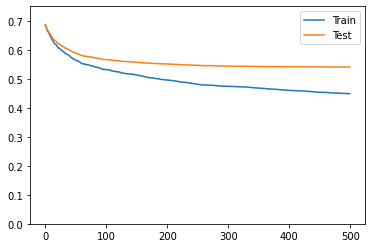

0.44869772871953556 0.5405505285162059


In [37]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])

#plt.savefig("training_rate_pionproton.pdf", format="pdf")

<Figure size 864x864 with 0 Axes>

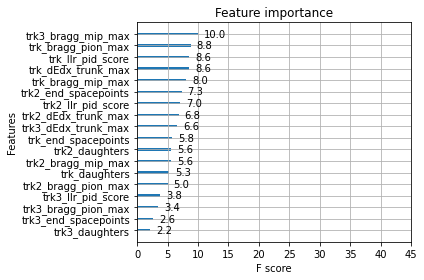

In [38]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(12,12),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=20,importance_type='gain')
plt.xlim(0, 45)
plt.tight_layout()
#plt.savefig("feature_importance_pionproton.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

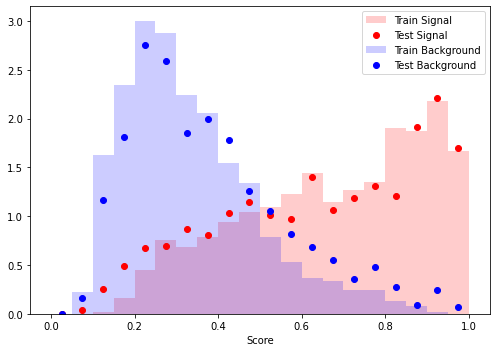

In [34]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_pionproton.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

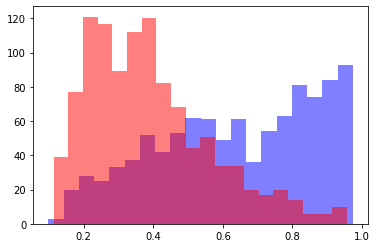

In [24]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

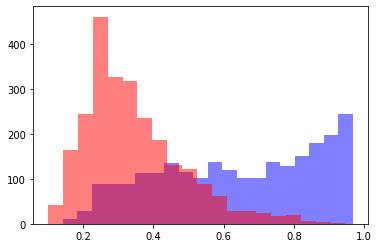

In [24]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()